In [2]:
import pandas as pd
from google.colab import files
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import os
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools import add_constant
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np


In [3]:
# Upload the file
uploaded = files.upload()

# Load the dataset
file_path = list(uploaded.keys())[0]
data = pd.read_csv(file_path)

Saving Housing.csv to Housing.csv


In [6]:
# Understand the Data
# Using Pandas to display general information about the dataset.
print("First 5 rows of the dataset:")
print(data.head())

print("\nDataset Info:")
print(data.info())

print("\nSummary Statistics:")
print(data.describe())

print("\nCheck for Missing Values:")
print(data.isnull().sum())

print("\nDataset Shape (Rows, Columns):")
print(data.shape)

print("\nDataset Columns:")
print(data.columns.tolist())

First 5 rows of the dataset:
      price  area  bedrooms  bathrooms  stories mainroad guestroom basement  \
0  13300000  7420         4          2        3      yes        no       no   
1  12250000  8960         4          4        4      yes        no       no   
2  12250000  9960         3          2        2      yes        no      yes   
3  12215000  7500         4          2        2      yes        no      yes   
4  11410000  7420         4          1        2      yes       yes      yes   

  hotwaterheating airconditioning  parking prefarea furnishingstatus  
0              no             yes        2      yes        furnished  
1              no             yes        3       no        furnished  
2              no              no        2      yes   semi-furnished  
3              no             yes        3      yes        furnished  
4              no             yes        2       no        furnished  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 e

In [7]:

#step 3: Check for Duplicates and remove if present
duplicates = data.duplicated()
print(f"Number of duplicate rows: {duplicates.sum()}")

if duplicates.sum() > 0:
    data = data[~duplicates]
    print(f"Data after removing duplicates: {data.shape}")

Number of duplicate rows: 0


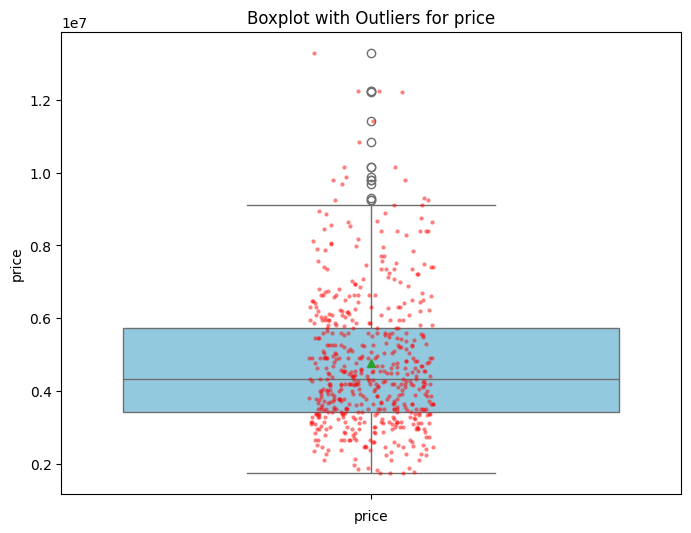

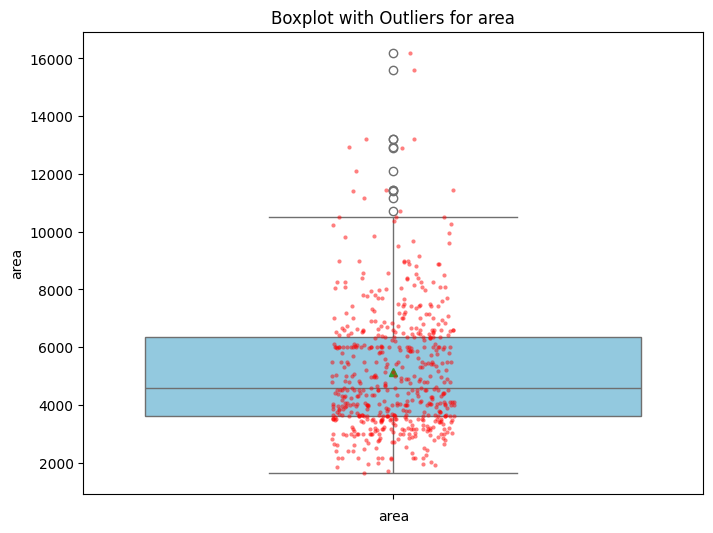

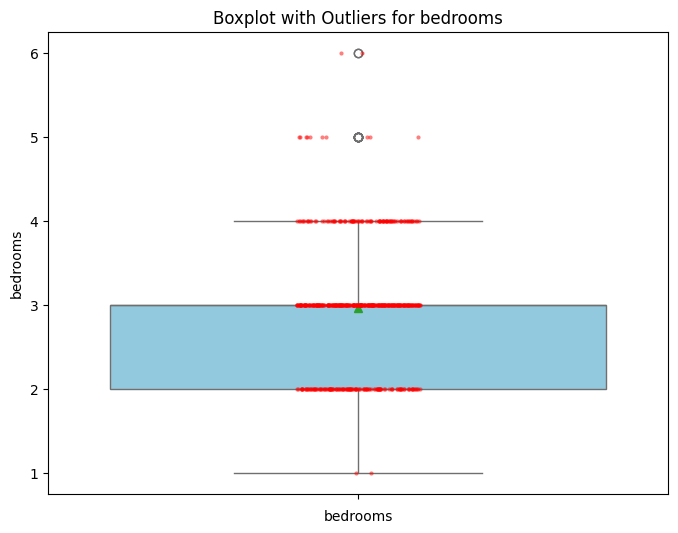

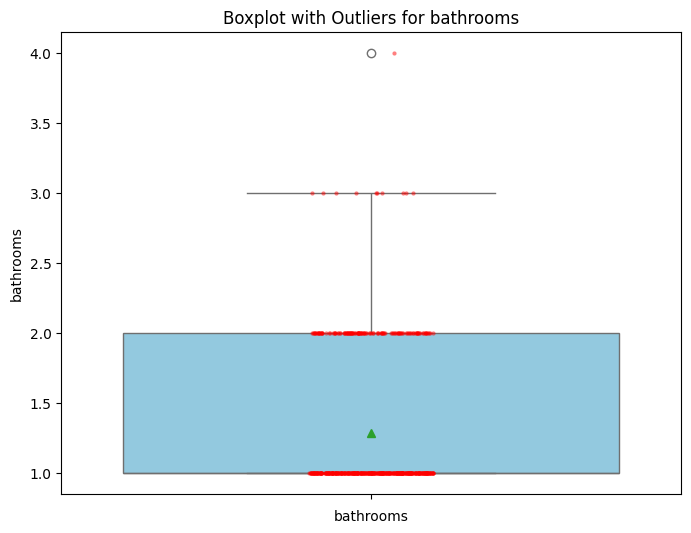

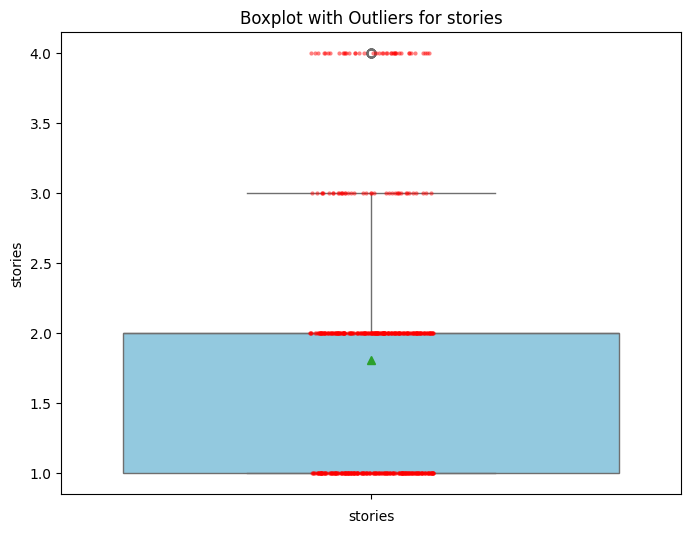

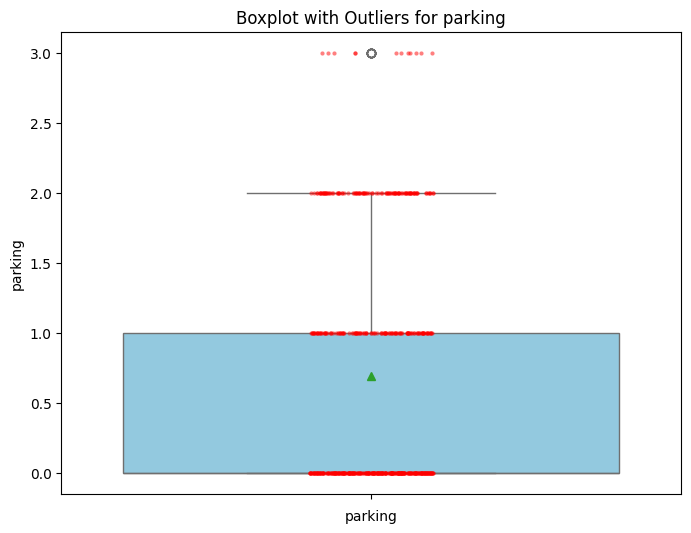

In [8]:
# Step 2: List of numerical columns
numerical_columns = ['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'parking']

# Step 3: Detect and Visualize Outliers for Each Column
for col in numerical_columns:
    # Plot a combined boxplot and swarmplot for each column
    plt.figure(figsize=(8, 6))
    sns.boxplot(data[col], color='skyblue', showmeans=True)
    sns.stripplot(data[col], color='red', alpha=0.5, jitter=True, size=3)
    plt.title(f"Boxplot with Outliers for {col}")
    plt.xlabel(col)
    plt.show()

In [9]:
# Detect and cap outliers in the price column
Q1 = data['price'].quantile(0.25)
Q3 = data['price'].quantile(0.75)
IQR = Q3 - Q1

# Calculate the bounds for capping
extreme_upper_bound = Q3 + 3 * IQR

# Cap the price column at the extreme upper bound
data['price'] = data['price'].clip(upper=extreme_upper_bound)

print(f"The maximum value of 'price' after capping: {data['price'].max()}")



The maximum value of 'price' after capping: 12670000


In [10]:
#List categorical columns
categorical_cols = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea', 'furnishingstatus']

#Encode categorical variables
label_enc = LabelEncoder()
for col in categorical_cols:
    data[col] = label_enc.fit_transform(data[col])

#Verify Encoding
print("\nEncoded Categorical Columns:")
print(data[categorical_cols].head())

#Check the final dataset structure
print("\nFinal Dataset Info:")
print(data.info())



Encoded Categorical Columns:
   mainroad  guestroom  basement  hotwaterheating  airconditioning  prefarea  \
0         1          0         0                0                1         1   
1         1          0         0                0                1         0   
2         1          0         1                0                0         1   
3         1          0         1                0                1         1   
4         1          1         1                0                1         0   

   furnishingstatus  
0                 0  
1                 0  
2                 1  
3                 0  
4                 0  

Final Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   price             545 non-null    int64
 1   area              545 non-null    int64
 2   bedrooms          545 non-null    int64
 3   b

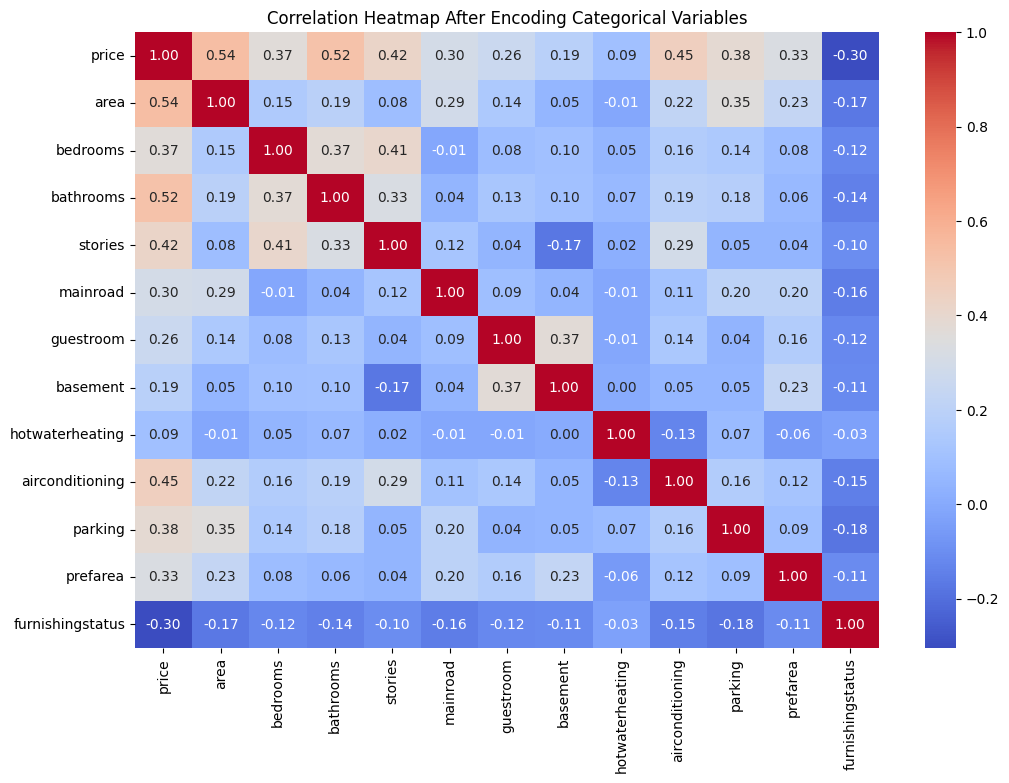

In [11]:
# Generate correlation heatmap after encoding categorical variables
plt.figure(figsize=(12, 8))
numerical_data = data.select_dtypes(include=['number'])  # Select all numerical columns (float64 and int64)
sns.heatmap(numerical_data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap After Encoding Categorical Variables")
plt.show()


In [12]:
#checking skewness

numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns
skewness = data[numerical_columns].skew()
print("Skewness of Numerical Features:\n", skewness)


Skewness of Numerical Features:
 price               1.187762
area                1.321188
bedrooms            0.495684
bathrooms           1.589264
stories             1.082088
mainroad           -2.065410
guestroom           1.688419
basement            0.628590
hotwaterheating     4.353428
airconditioning     0.795748
parking             0.842062
prefarea            1.254361
furnishingstatus   -0.117666
dtype: float64


Skewed Features: Index(['price', 'area', 'bathrooms', 'stories', 'guestroom', 'hotwaterheating',
       'airconditioning', 'parking', 'prefarea'],
      dtype='object')
Skewness After Transformation:
 price              0.135874
area               0.133747
bathrooms          1.310299
stories            0.525950
guestroom          1.688419
hotwaterheating    4.353428
airconditioning    0.795748
parking            0.501800
prefarea           1.254361
dtype: float64


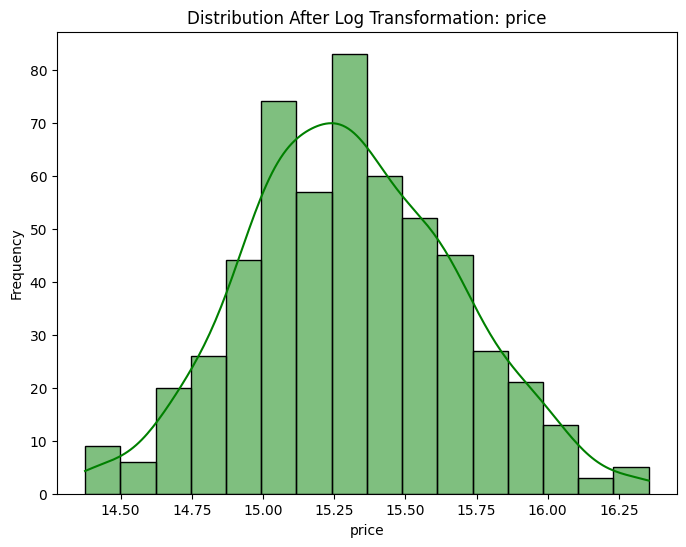

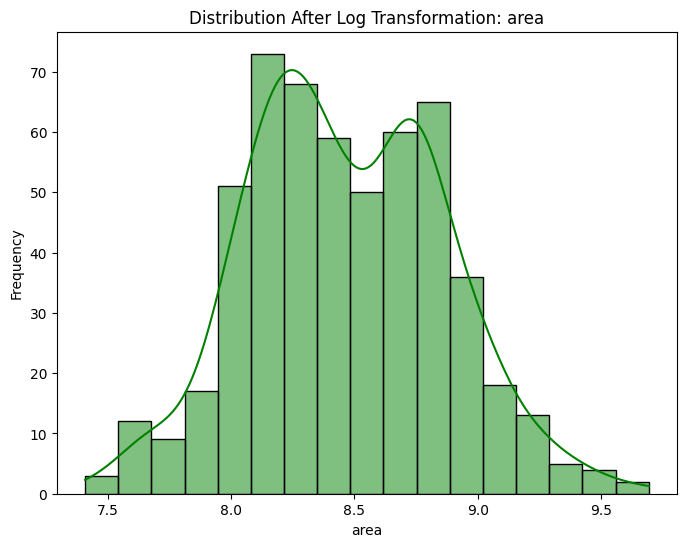

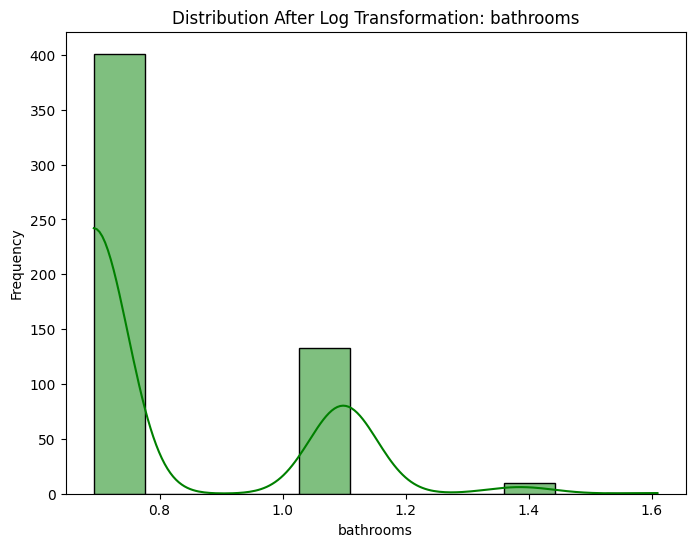

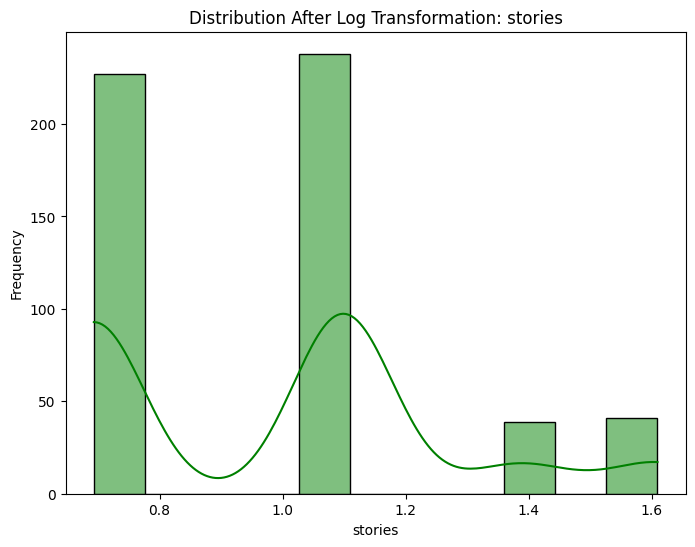

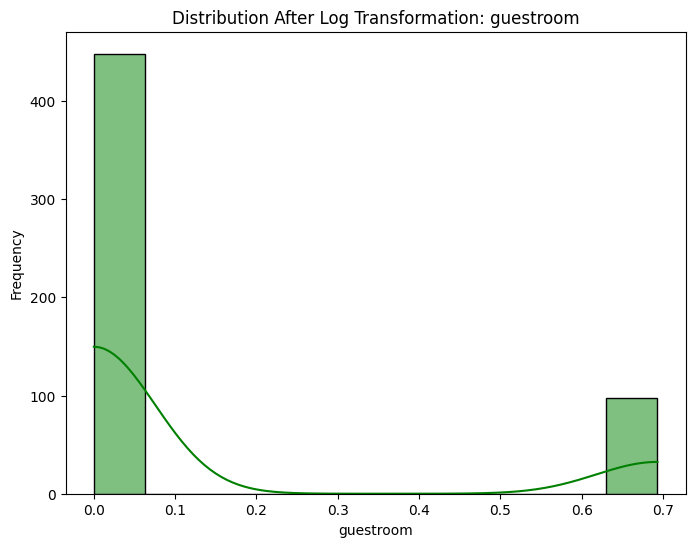

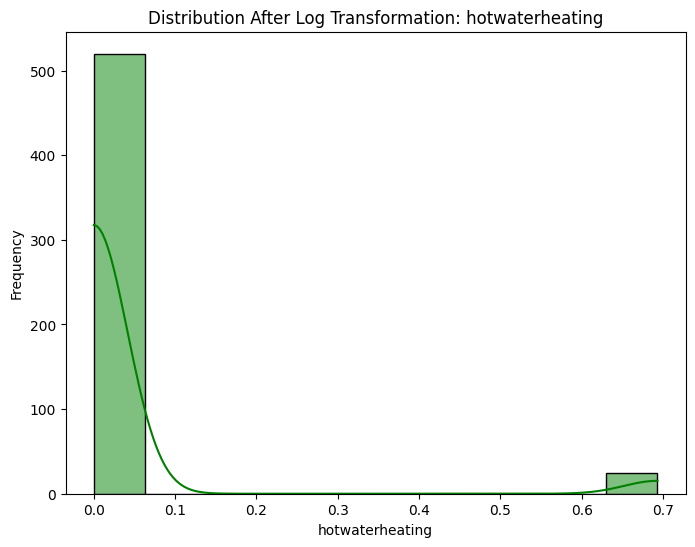

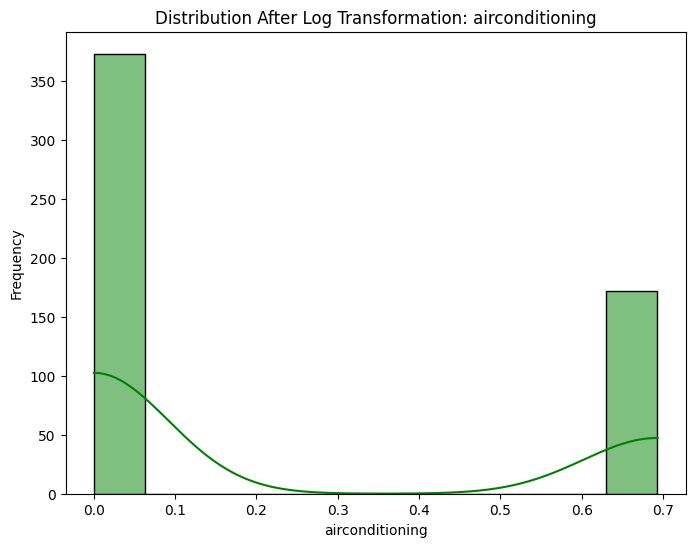

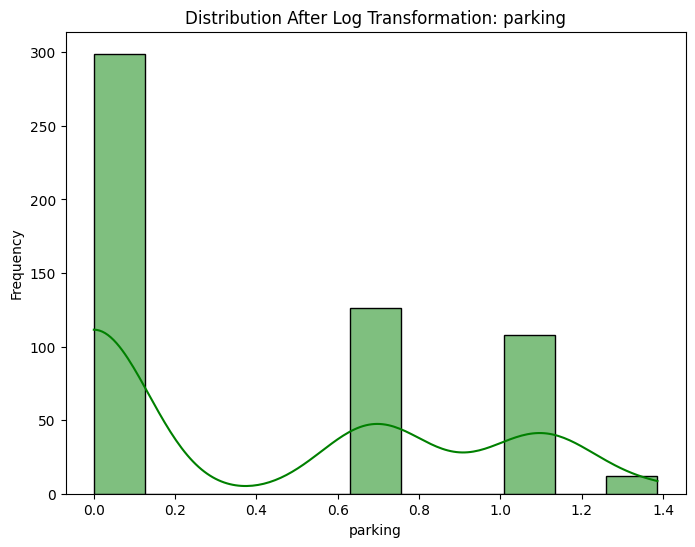

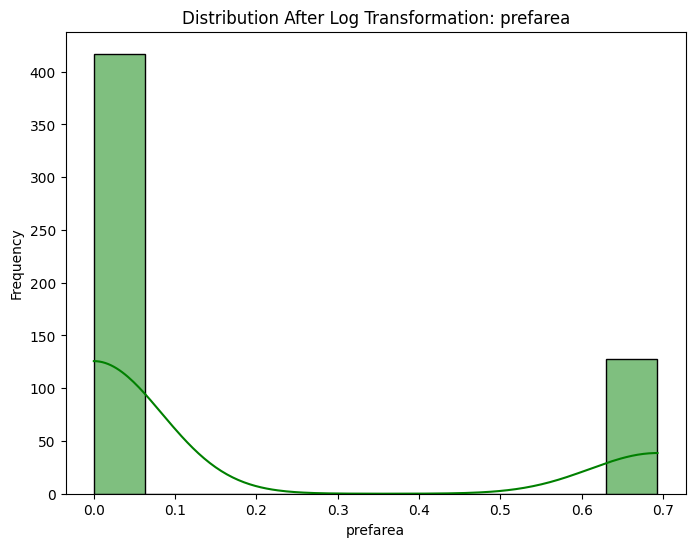

In [13]:
# Addressing Skewed Features with Log Transformations (0.75 as threshold)
skewed_features = skewness[skewness > 0.75].index
print(f"Skewed Features: {skewed_features}")

for feature in skewed_features:
    data[feature] = np.log1p(data[feature])

# Check skewness after transformation
skewness_after = data[skewed_features].skew()
print("Skewness After Transformation:\n", skewness_after)

# Visualize distributions after transformation
for feature in skewed_features:
    plt.figure(figsize=(8, 6))
    sns.histplot(data[feature], kde=True, color='green')
    plt.title(f"Distribution After Log Transformation: {feature}")
    plt.xlabel(feature)
    plt.ylabel("Frequency")
    plt.show()


In [15]:
#SPLITTING MODEL INTO TEST AND TRAIN#

# Step 1: Define features and target
X = data.drop(columns=['price'])
y = data['price']  #target variable

# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the shapes of the splits
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")




X_train shape: (436, 12)
X_test shape: (109, 12)
y_train shape: (436,)
y_test shape: (109,)


In [16]:
# Step 3: Initialize Model
model = LinearRegression()
#trains model on training dataset
model.fit(X_train, y_train)

# Step 4: Make Predictions
y_pred_train = model.predict(X_train)  # Predictions on training data
y_pred_test = model.predict(X_test)  # Predictions on testing data

# Step 5: Evaluate the Model
print("\nModel Performance:")
print("Training Set:")
print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_train, y_pred_train):.2f}")
print(f"Mean Squared Error (MSE): {mean_squared_error(y_train, y_pred_train):.2f}")
print(f"R² Score: {r2_score(y_train, y_pred_train):.2f}")

print("\nTesting Set:")
print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_test, y_pred_test):.2f}")
print(f"Mean Squared Error (MSE): {mean_squared_error(y_test, y_pred_test):.2f}")
print(f"R² Score: {r2_score(y_test, y_pred_test):.2f}")



Model Performance:
Training Set:
Mean Absolute Error (MAE): 0.15
Mean Squared Error (MSE): 0.04
R² Score: 0.71

Testing Set:
Mean Absolute Error (MAE): 0.20
Mean Squared Error (MSE): 0.06
R² Score: 0.67
